### Student Information
Name: Hadar Natanson (Harper/羅蕙)

Student ID: 112065430

GitHub ID: Hadar-N

Kaggle name: hadarnatanson

Kaggle private scoreboard snapshot:

[Snapshot](img/pic0.png)

---

### Instructions

1. First: __This part is worth 30% of your grade.__ Do the **take home** exercises in the DM2023-Lab2-master. You may need to copy some cells from the Lab notebook to this notebook. 


2. Second: __This part is worth 30% of your grade.__ Participate in the in-class [Kaggle Competition](https://www.kaggle.com/t/09b1d0f3f8584d06848252277cb535f2) regarding Emotion Recognition on Twitter by this link https://www.kaggle.com/t/09b1d0f3f8584d06848252277cb535f2. The scoring will be given according to your place in the Private Leaderboard ranking: 
    - **Bottom 40%**: Get 20% of the 30% available for this section.

    - **Top 41% - 100%**: Get (60-x)/6 + 20 points, where x is your ranking in the leaderboard (ie. If you rank 3rd your score will be (60-3)/6 + 20 = 29.5% out of 30%)   
    Submit your last submission __BEFORE the deadline (Dec. 27th 11:59 pm, Wednesday)_. Make sure to take a screenshot of your position at the end of the competition and store it as '''pic0.png''' under the **img** folder of this repository and rerun the cell **Student Information**.
    

3. Third: __This part is worth 30% of your grade.__ A report of your work developping the model for the competition (You can use code and comment it). This report should include what your preprocessing steps, the feature engineering steps and an explanation of your model. You can also mention different things you tried and insights you gained. 


4. Fourth: __This part is worth 10% of your grade.__ It's hard for us to follow if your code is messy :'(, so please **tidy up your notebook** and **add minimal comments where needed**.


Upload your files to your repository then submit the link to it on the corresponding e-learn assignment.

Make sure to commit and save your changes to your repository __BEFORE the deadline (Dec. 31th 11:59 pm, Sunday)__. 

In [8]:
### Begin Assignment Here

# TODO: Add Kaggle location

# Part 1-

# imports
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.metrics import accuracy_score, confusion_matrix
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import accuracy_score
from sklearn.preprocessing import LabelEncoder
from sklearn.manifold import TSNE
import nltk
import seaborn as sns
import itertools
import keras
from keras.callbacks import CSVLogger
from keras.models import Model
from keras.layers import Input, Dense
from keras.layers import ReLU, Softmax
from gensim.models import KeyedVectors
import warnings

warnings.filterwarnings('ignore')

# nltk.download('punkt')
# nltk.download('stopwords')

%matplotlib inline


# copied from Lab file:
anger_train = pd.read_csv("data/semeval/train/anger-ratings-0to1.train.txt",
                         sep="\t", header=None,names=["id", "text", "emotion", "intensity"])
sadness_train = pd.read_csv("data/semeval/train/sadness-ratings-0to1.train.txt",
                         sep="\t", header=None, names=["id", "text", "emotion", "intensity"])
fear_train = pd.read_csv("data/semeval/train/fear-ratings-0to1.train.txt",
                         sep="\t", header=None, names=["id", "text", "emotion", "intensity"])
joy_train = pd.read_csv("data/semeval/train/joy-ratings-0to1.train.txt",
                         sep="\t", header=None, names=["id", "text", "emotion", "intensity"])

train_df = pd.concat([anger_train, fear_train, joy_train, sadness_train], ignore_index=True)

anger_test = pd.read_csv("data/semeval/dev/anger-ratings-0to1.dev.gold.txt",
                         sep="\t", header=None, names=["id", "text", "emotion", "intensity"])
sadness_test = pd.read_csv("data/semeval/dev/sadness-ratings-0to1.dev.gold.txt",
                         sep="\t", header=None, names=["id", "text", "emotion", "intensity"])
fear_test = pd.read_csv("data/semeval/dev/fear-ratings-0to1.dev.gold.txt",
                         sep="\t", header=None, names=["id", "text", "emotion", "intensity"])
joy_test = pd.read_csv("data/semeval/dev/joy-ratings-0to1.dev.gold.txt",
                         sep="\t", header=None, names=["id", "text", "emotion", "intensity"])

test_df = pd.concat([anger_test, fear_test, joy_test, sadness_test], ignore_index=True)
train_df.head()

train_df = train_df.sample(frac=1)
test_df = test_df.sample(frac=1)

BOW_vectorizer = CountVectorizer() 
BOW_vectorizer.fit(train_df['text'])

train_data_BOW_features = BOW_vectorizer.transform(train_df['text'])
test_data_BOW_features = BOW_vectorizer.transform(test_df['text'])

BOW_500 = CountVectorizer(max_features=500, tokenizer=nltk.word_tokenize) 

# apply analyzer to training data
BOW_500.fit(train_df['text'])

# train_data_BOW_features_500 = BOW_500.transform(train_df['text'])

X_train = BOW_500.transform(train_df['text'])
y_train = train_df['emotion']

X_test = BOW_500.transform(test_df['text'])
y_test = test_df['emotion']

my_tags = ['anger', 'fear', 'joy', 'sadness']

def plot_confusion_matrix(cm, classes, title='Confusion matrix',
                          cmap=sns.cubehelix_palette(as_cmap=True)):
    """
    This function is modified from: 
    http://scikit-learn.org/stable/auto_examples/model_selection/plot_confusion_matrix.html
    """
    classes.sort()
    tick_marks = np.arange(len(classes))    
    
    fig, ax = plt.subplots(figsize=(5,5))
    im = ax.imshow(cm, interpolation='nearest', cmap=cmap)
    ax.figure.colorbar(im, ax=ax)
    ax.set(xticks=np.arange(cm.shape[1]),
           yticks=np.arange(cm.shape[0]),
           xticklabels = classes,
           yticklabels = classes,
           title = title,
           xlabel = 'True label',
           ylabel = 'Predicted label')

    fmt = 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt), horizontalalignment="center", color="white" if cm[i, j] > thresh else "black")
    ylim_top = len(classes) - 0.5
    plt.ylim([ylim_top, -.5])
    plt.tight_layout()
    plt.show()

label_encoder = LabelEncoder()
label_encoder.fit(y_train)

def label_encode(le, labels):
    enc = le.transform(labels)
    return keras.utils.to_categorical(enc)

def label_decode(le, one_hot_label):
    dec = np.argmax(one_hot_label, axis=1)
    return le.inverse_transform(dec)

input_shape = X_train.shape[1]
output_shape = len(label_encoder.classes_)

# input layer
model_input = Input(shape=(input_shape, ))  # 500
X = model_input

# 1st hidden layer
X_W1 = Dense(units=64)(X)  # 64
H1 = ReLU()(X_W1)

# 2nd hidden layer
H1_W2 = Dense(units=64)(H1)  # 64
H2 = ReLU()(H1_W2)

# output layer
H2_W3 = Dense(units=output_shape)(H2)  # 4
H3 = Softmax()(H2_W3)

model_output = H3

print("AAAAAAAAAAAAAAAAa")
# create model
model = Model(inputs=[model_input], outputs=[model_output])

# loss function & optimizer
model.compile(optimizer='adam',
              loss='categorical_crossentropy',
              metrics=['accuracy'])
print("BBBBBBBBBBBBBBBBBBBB")

# show model construction
model.summary()

csv_logger = CSVLogger('logs/training_log.csv')
print("CCCCCCCCCCCCCCCCCCCCC")

# training setting
epochs = 25
batch_size = 32

# training!
history = model.fit(X_train, y_train, 
                    epochs=epochs, 
                    batch_size=batch_size, 
                    callbacks=[csv_logger],
                    validation_data = (X_test, y_test))
print('training finish')
pred_result = model.predict(X_test, batch_size=128)
pred_result = label_decode(label_encoder, pred_result)
print("DDDDDDDDDDDDDDDDDDDDDDDDD")

training_log = pd.DataFrame()
training_log = pd.read_csv("logs/training_log.csv")


## Note: this model is very huge, this will take some time ...
model_path = "GoogleNews-vectors-negative300.bin.gz"
w2v_google_model = KeyedVectors.load_word2vec_format(model_path, binary=True)


AAAAAAAAAAAAAAAAa
BBBBBBBBBBBBBBBBBBBB
Model: "model_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_5 (InputLayer)        [(None, 500)]             0         
                                                                 
 dense_12 (Dense)            (None, 64)                32064     
                                                                 
 re_lu_8 (ReLU)              (None, 64)                0         
                                                                 
 dense_13 (Dense)            (None, 64)                4160      
                                                                 
 re_lu_9 (ReLU)              (None, 64)                0         
                                                                 
 dense_14 (Dense)            (None, 4)                 260       
                                                                 
 softmax_4 (Softmax)

ValueError: in user code:

    File "c:\Users\hadar\Documents\studies\venv2\Lib\site-packages\keras\src\engine\training.py", line 1401, in train_function  *
        return step_function(self, iterator)
    File "c:\Users\hadar\Documents\studies\venv2\Lib\site-packages\keras\src\engine\training.py", line 1384, in step_function  **
        outputs = model.distribute_strategy.run(run_step, args=(data,))
    File "c:\Users\hadar\Documents\studies\venv2\Lib\site-packages\keras\src\engine\training.py", line 1373, in run_step  **
        outputs = model.train_step(data)
    File "c:\Users\hadar\Documents\studies\venv2\Lib\site-packages\keras\src\engine\training.py", line 1151, in train_step
        loss = self.compute_loss(x, y, y_pred, sample_weight)
    File "c:\Users\hadar\Documents\studies\venv2\Lib\site-packages\keras\src\engine\training.py", line 1209, in compute_loss
        return self.compiled_loss(
    File "c:\Users\hadar\Documents\studies\venv2\Lib\site-packages\keras\src\engine\compile_utils.py", line 277, in __call__
        loss_value = loss_obj(y_t, y_p, sample_weight=sw)
    File "c:\Users\hadar\Documents\studies\venv2\Lib\site-packages\keras\src\losses.py", line 143, in __call__
        losses = call_fn(y_true, y_pred)
    File "c:\Users\hadar\Documents\studies\venv2\Lib\site-packages\keras\src\losses.py", line 270, in call  **
        return ag_fn(y_true, y_pred, **self._fn_kwargs)
    File "c:\Users\hadar\Documents\studies\venv2\Lib\site-packages\keras\src\losses.py", line 2221, in categorical_crossentropy
        return backend.categorical_crossentropy(
    File "c:\Users\hadar\Documents\studies\venv2\Lib\site-packages\keras\src\backend.py", line 5573, in categorical_crossentropy
        target.shape.assert_is_compatible_with(output.shape)

    ValueError: Shapes (None, 1) and (None, 4) are incompatible


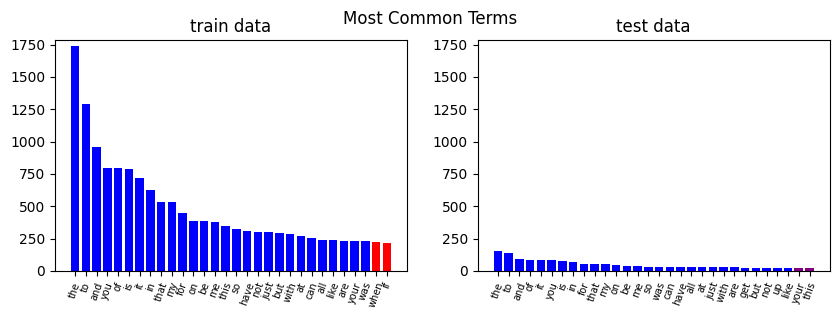

['bitter' 'black' 'blacks' 'blame' 'blessed' 'blood' 'bloody' 'blues'
 'body' 'boiling']
multi_nb train accuracy: 0.79
multi_nb test accuracy: 0.7


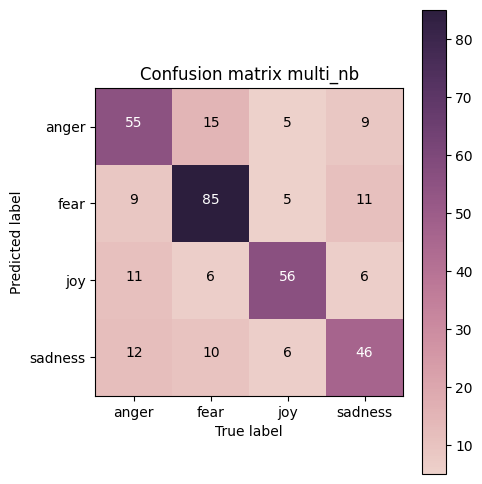

NameError: name 'training_log' is not defined

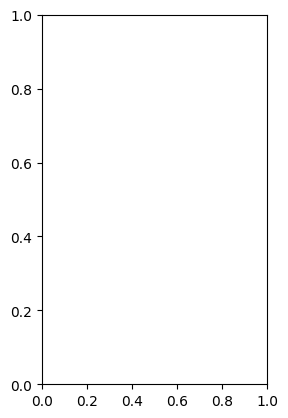

In [7]:
# TODO: add comments!

# Exercise 1:
TERMS_PER_PLOT = 30
count_vect_train = CountVectorizer()
count_vect_test = CountVectorizer()
train_counts = count_vect_train.fit_transform(train_df.text) #learn the vocabulary and return document-term matrix
test_counts = count_vect_test.fit_transform(test_df.text) #learn the vocabulary and return document-term matrix

term_frequencies_train = np.asarray(train_counts.sum(axis=0))[0]
term_frequencies_test = np.asarray(test_counts.sum(axis=0))[0]

bar_df_train = pd.DataFrame(dict(
    term = count_vect_train.get_feature_names_out(),
    count = term_frequencies_train)).sort_values(by="count", ascending=False)

bar_df_test = pd.DataFrame(dict(
    term = count_vect_test.get_feature_names_out(),
    count = term_frequencies_test)).sort_values(by="count", ascending=False)

ylim = bar_df_train["count"].max() + 50
s1=bar_df_train["term"][:30]
s2=bar_df_test["term"][:30]

set_1_unique_words = set(s1)-set(s2)
set_2_unique_words = set(s2)-set(s1)
colors_s_1 = [("red" if word in set_1_unique_words else "blue") for word in s1]
colors_s_2 = [("purple" if word in set_1_unique_words else "blue") for word in s1]

f = plt.figure(figsize=(10,3))
f.suptitle('Most Common Terms')

ax = f.add_subplot(121)
ax.bar(s1, bar_df_train["count"][:30], color=colors_s_1)
ax.set_title("train data")
ax.set_ylim(0,ylim)
ax.tick_params(axis='x', rotation=70, labelsize= 7)

ax2 = f.add_subplot(122)
ax2.bar(s2, bar_df_test["count"][:30], color=colors_s_2)
ax2.set_title("test data")
ax2.set_ylim(0,ylim)
ax2.tick_params(axis='x', rotation=70, labelsize= 7)

plt.show()
# TODO: merge charts?
# TODO: remove stopwords!


# Exercise 2:
tf_idf_vectorizer_1000 = TfidfVectorizer(max_features=1000)
tf_idf_1000 = tf_idf_vectorizer_1000.fit_transform(train_df['text'])
print(tf_idf_vectorizer_1000.get_feature_names_out()[100:110])


# Exercise 3:
# The Confusion Matrix shows the distribution of how accurate the training model is across the different labels, which means how many labels were predicted correctly, and ho many were predicted into other labels.
# Based on the matrix, we can see most texts were tagged correctly. The label with the highest accuracy rate would be joy- given it was barely labeled incorrectly.
# In addition, we can see anger/fear labels are confused more often than other labels, followed by sadness/fear incorrect labeling.

# Exercise 4:
# TODO: solution is... meh

multi_nb = MultinomialNB()
multi_nb.fit(X_train,y_train)

y_train_pred_mnb = multi_nb.predict(X_train)
y_test_pred_mnb = multi_nb.predict(X_test)

acc_train_score = accuracy_score(y_train_pred_mnb, y_train)
acc_test_score = accuracy_score(y_test_pred_mnb, y_test)

print('multi_nb train accuracy:', format(round(acc_train_score, 2)))
print('multi_nb test accuracy:', format(round(acc_test_score, 2)))

plot_confusion_matrix(confusion_matrix(y_true=y_test, y_pred=y_test_pred_mnb), classes=my_tags, title='Confusion matrix multi_nb')


# Exercise 5:
# TODO: if exercise 4 is optimized, this answer should be updated!

# The accuracy results for the different models are very different:
# For the train data prediction, we are receiving a much lower score (0.79 using multi_nb compared to 0.99 using decision tree). Given the prediction using decision tree was suspiciously high, this isn't neccessarily a bad thing.
# For the test data we receive a bit higher score than before (0.7 using multi_nb compared to 0.68 using decision tree)- which is pretty good news. since there is a lot of data (347 texts in the test dataset), an 0.2 difference could effect overall of almost 7 texts.
# Moreover, since the difference in accuracy between the train_data and test_data is quite small (less than 0.1), we can assume the overfitting issue has been solved (even if the model itself is far from being ideal yet).
# Looking at the confusion matrix visualization, we can see the fear label is better recognized using multi_nb, while the overall label recognition mistakes are less concentrated in one area
# (before, 3 different innacurate groups had over 10 items- 2 of which were in fear/anger recognition.now, there are 5 such groups, with fear/anger still in the first place (by lower margin), and sadness/anger and fear/sadness tying in the second place).

# Exercise 6:
fig = plt.figure()

acc = fig.add_subplot(1, 2, 1)
plt.plot(training_log["accuracy"], label = "Training accuracy") 
plt.plot(training_log["val_accuracy"], label = "Validation accuracy") 
plt.legend()
plt.xlabel("epochs")
plt.ylabel("accuracy")
plt.title("accuracy comparison")

acc = fig.add_subplot(1, 2, 2)
plt.plot(training_log["loss"], label = "Training loss") 
plt.plot(training_log["val_loss"], label = "Validation loss") 
plt.legend()
plt.xlabel("epochs")
plt.ylabel("loss")
plt.title("loss comparison")

plt.tight_layout(pad=3.0)
plt.show()

#Explanations:
#Accuracy comparison: For the first few epochs the model is doing well with both training and validation accuracy going up together. later the validation accuracy gets stuck while the training accuracy keeps on going higher.
#       This shows the model is probably overfitting itself to the training data, getting more accurate for it, but having no improvement for general data (in this case, the validation accuracy.)
#Loss comparison: The training loss is much higher than the validation loss, and so it supports our claims of overfitting.
#       The validation loss gets higher, the training loss gets lower and the overall difference between the two grow as we train the data.

# Exercise 7:
sentence = "chocolate is the most amazing thing in the world"
VALUE_COUNT = 100
# TODO: add methods?
# TODO: "key is not presented in data"/remove filler words?

# Method 1: summing up the similarity of all most similar words, trying to find if there are doubles/the most similar word in the group
# According to The Brevity Law, most common words tend to be shorter. Assuming that "filler words" or words that can have multiple different meanings are both more common and less helpful to understand the sentence's meaning, based on this law, it would mean they will also be shorter.

stop_words = set(nltk.corpus.stopwords.words('english'))
sent_arr = [w for w in sentence.split() if not w.lower() in stop_words]
total_length = sum(map(len, sent_arr))

df = pd.DataFrame(None, columns =['Name', 'Score'])

for item in sent_arr:
    temp_df = pd.DataFrame(w2v_google_model.most_similar(item, topn=VALUE_COUNT), columns =['Name', 'Score'])
    # calc score related to the "importance" (length) of each word in the sentence
    temp_df["Score"] *= len(item)/total_length
    # separate the words that already appearred in the list from the new vocabulary
    same_keys = temp_df[temp_df["Name"].isin(df["Name"])]
    diff_keys = temp_df[-temp_df["Name"].isin(df["Name"])].set_index('Name', drop=False)

    # sum the similarity for the re-appearing items
    for idx,val in same_keys.iterrows():
        df.at[val["Name"],"Score"] += val["Score"]

    #add to the overall list the new vocab
    df = pd.concat([df, diff_keys])

df.sort_values(by=['Score'], ascending=False).head(10)


# Exercise 8

## w2v model
word_list = ['happy', 'angry', 'data', 'mining']

topn = 15
happy_words = ['happy'] + [word_ for word_, sim_ in w2v_google_model.most_similar('happy', topn=topn)]
angry_words = ['angry'] + [word_ for word_, sim_ in w2v_google_model.most_similar('angry', topn=topn)]        
data_words = ['data'] + [word_ for word_, sim_ in w2v_google_model.most_similar('data', topn=topn)]        
mining_words = ['mining'] + [word_ for word_, sim_ in w2v_google_model.most_similar('mining', topn=topn)]        

target_words = happy_words + angry_words + data_words + mining_words
cn = topn + 1
color = ['b'] * cn + ['g'] * cn + ['r'] * cn + ['y'] * cn

## prepare training word vectors
size = 200
target_size = len(target_words)
all_word = list(w2v_google_model.index_to_key)
word_train = target_words + all_word[:size]
X_train = w2v_google_model[word_train]

## t-SNE model
tsne = TSNE(n_components=2, metric='cosine', random_state=42)

## training
X_tsne = tsne.fit_transform(X_train)

## plot the result
plt.figure(figsize=(7.5, 7.5), dpi=115)
plt.scatter(X_tsne[:target_size, 0], X_tsne[:target_size, 1], c=color)
for label, x, y in zip(target_words, X_tsne[:target_size, 0], X_tsne[:target_size, 1]):
    plt.annotate(label, xy=(x,y), xytext=(0,0),  textcoords='offset points')
plt.show()
